# k-NN Breast Cancer Classification
### 프로젝트 설명

In [3]:
import os
from utils.paths import get_data_path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

## 1) 데이터 로딩 & 시각화

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

C:\Users\정호진\AppData\Local\Temp\ipykernel_21280\2766537752.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["diagnosis"] = df["diagnosis"].replace({"M":1, "B":0})


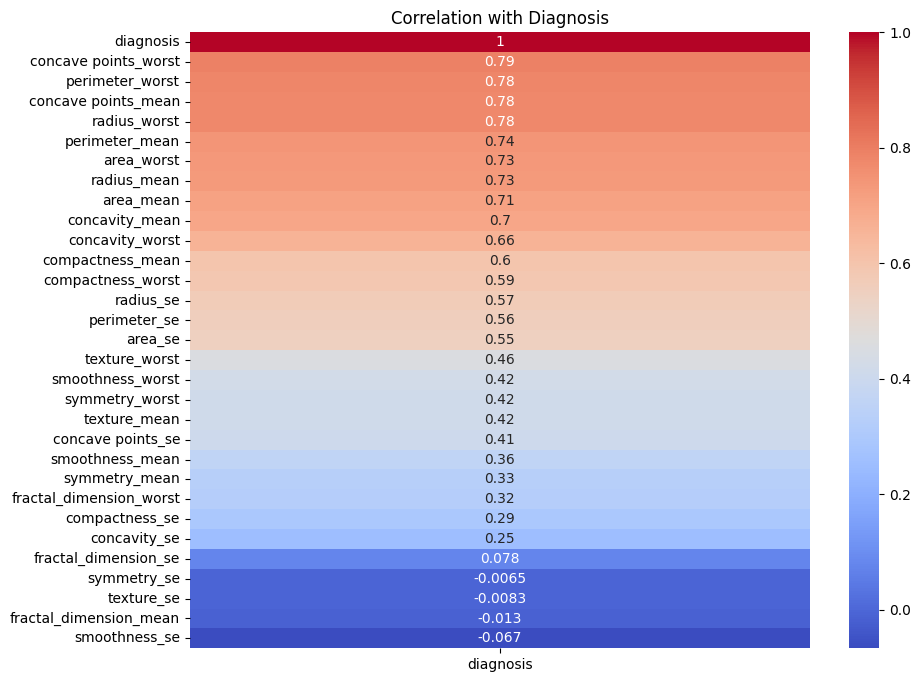

In [4]:
csv_path = get_data_path("breast-cancer.csv")
df = pd.read_csv(csv_path)
df.info()

#ID칼럼 제거 및 target값 수치형으로 변환
df = df.drop(columns=["id"])

#target을 범주형으로 변환 M(악성), B(양성)
df["diagnosis"] = df["diagnosis"].replace({"M":1, "B":0})
df.head()

#target과 다른 변수간의 상관관계 시각화
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr[['diagnosis']].sort_values(by='diagnosis', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlation with Diagnosis')
plt.show()

## 2) 전처리 & 분할 (Min-Max Scaling)

### 8:2 분할

In [5]:
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

X_train_scale.shape, X_test_scale.shape, y_train.shape, y_test.shape


((455, 30), (114, 30), (455,), (114,))

## 3) k 값 튜닝

#### 홀수값으로 튜닝하는 이유는 동률 투표 배제를 위해

In [6]:
results = []
for k in range(1, 32, 2):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scale, y_train)
    pred = model.predict(X_test_scale)
    acc = accuracy_score(y_test, pred)
    sens = recall_score(y_test, pred, pos_label=1)
    results.append((k, acc, sens))

res_df = pd.DataFrame(results, columns=["k","accuracy","sensitivity"])
res_df


,k,accuracy,sensitivity
0,1,0.929825,0.880952
1,3,0.956140,0.904762
2,5,0.956140,0.904762
3,7,0.964912,0.928571
4,9,0.964912,0.928571
5,11,0.964912,0.928571
6,13,0.964912,0.904762
7,15,0.956140,0.880952
8,17,0.956140,0.880952
9,19,0.947368,0.857143


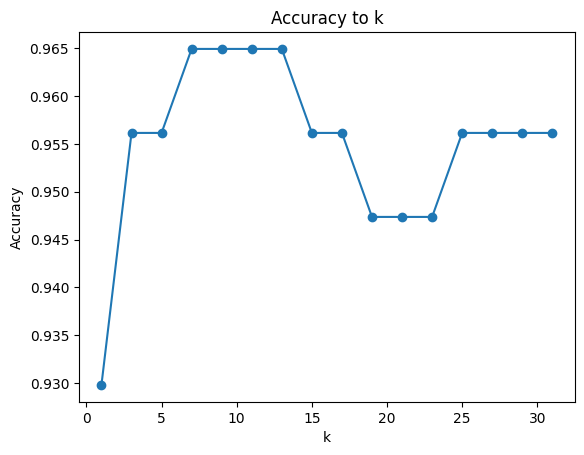

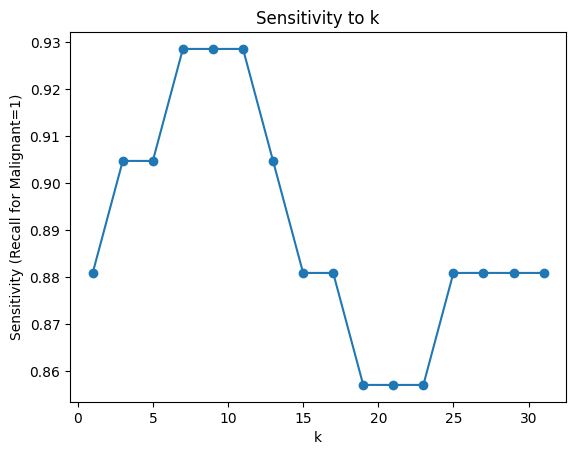

In [7]:
# Accuracy to k
plt.figure()
plt.plot(res_df['k'], res_df['accuracy'], marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy to k')
plt.show()

# Sensitivity to k
plt.figure()
plt.plot(res_df['k'], res_df['sensitivity'], marker='o')
plt.xlabel('k')
plt.ylabel('Sensitivity (Recall for Malignant=1)')
plt.title('Sensitivity to k')
plt.show()


## 4) Best practice 최적해

In [8]:
best_practice = res_df.iloc[res_df['accuracy'].idxmax()]
best_k = int(best_practice['k'])
best_acc = float(best_practice['accuracy'])
best_sens = float(best_practice['sensitivity'])
print(f"Best k by Accuracy: k={best_k}, Accuracy={best_acc:.4f}, Sensitivity={best_sens:.4f}")


Best k by Accuracy: k=7, Accuracy=0.9649, Sensitivity=0.9286


## 5) 최적의 k로 모델 학습 & 평가

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train_scale, y_train)
y_pred = knn.predict(X_test_scale)
y_proba = knn.predict_proba(X_test_scale)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Benign(0)","Malignant(1)"]))

acc = accuracy_score(y_test, y_pred)
sens = recall_score(y_test, y_pred, pos_label=1)
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity(Recall for Malignant=1): {sens:.4f}")

if y_proba is not None:
    try:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {auc:.4f}")
    except Exception as e:
        print("ROC-AUC 계산 불가:", e)




Confusion Matrix:
 [[71  1]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

   Benign(0)       0.96      0.99      0.97        72
Malignant(1)       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Accuracy: 0.9649
Sensitivity(Recall for Malignant=1): 0.9286
ROC-AUC: 0.9957


## 6) 상관계수 상위 10개의 변수만으로 학습 및 기존 결과와 비교 

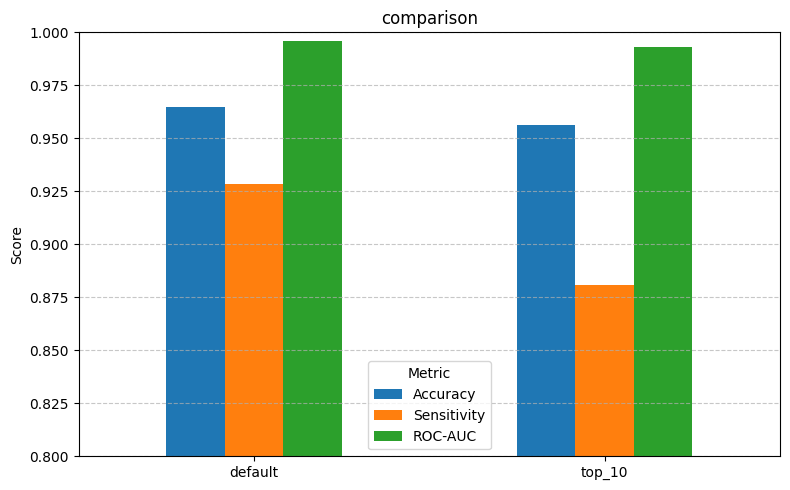

         Accuracy  Sensitivity   ROC-AUC
default  0.964912     0.928571  0.995701
top_10   0.956140     0.880952  0.992890


In [10]:
default_X = df.drop(columns=["diagnosis"])
corr = df.corr(numeric_only=True)['diagnosis'].sort_values(ascending=False)
top10_feature = corr.index[1:11]

top10_X = df[top10_feature]

#간편화를 위해 KNN 함수화
def knn_eval(features):
    X = df[features]
    y = df['diagnosis']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test)[:, 1]
    
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Sensitivity": recall_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }


default_result = knn_eval(default_X.columns)
top10_result = knn_eval(top10_feature)

#비교표
comparison = pd.DataFrame([default_result, top10_result], index=["default", "top_10"])
comparison

#시각화
comparison.plot(kind='bar', figsize=(8, 5))
plt.title('comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0.8, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

print(comparison)





    


- K-NN은 **거리기반 모델이라,** 관련 변수들이 많을수록 **결정 경계가 정교해질 가능성**이 있음
- 상관계수가 낮더라도 **일부 변수는 독립적으로 중요한 정보를 제공**하고 있을 가능성이 있음
- 단변량 기준이기 때문에 **다변량에서 발생하는 변수간 시너시는 반영이 안됨**